In [1]:
import copy
from PIL import Image, ImageDraw
import numpy as np
import torch
import pandas as pd
import os
from math import ceil
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch import nn
import optuna
from optuna.trial import TrialState
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [2]:
MAX_SIZE = 640

In [3]:
def calcNewDimsWH(width, height, maxSize):
    """ calc dims for downscale image according to maximum allowed size """
    
    if width < height:
        newHeight = maxSize
        ratio = height/maxSize
        newWidth = ceil(width/ratio)
    else:
        newWidth = maxSize
        ratio = width/maxSize
        newHeight = ceil(height/ratio)
        
    return newWidth, newHeight



def convertLabelCsvSize(old_csv, new_csv, width, height, equal_size):

    df = pd.read_csv(old_csv, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
    
    if equal_size:
        new_width = width
        new_height = height
        
    else:
        new_width = []
        new_height = []
        
        for w, h in zip(df.w, df.h):
            new_w, new_h = calcNewDimsWH(w, h, MAX_SIZE)
            new_width.append(new_w)
            new_height.append(new_h)
            
        new_width = np.array(new_width)
        new_height = np.array(new_height)
    
    c1 = np.round(df.c1/df.w * new_width).astype('int')
    c2 = np.round(df.c2/df.h * new_height).astype('int')
    c3 = np.round(df.c3/df.w * new_width).astype('int')
    c4 = np.round(df.c4/df.h * new_height).astype('int')
    df2 = pd.DataFrame({'target':df.target, 'c1':c1, 'c2':c2, 'c3':c3, 'c4':c4, 'imageFile':df.imageFile, 'w':new_width, 'h':new_height}, columns=None)
        
    df2.to_csv(new_csv, header=False, index=False)
    
    


In [4]:
imageFolder = 'roi_test_set_max640'
old_csv = 'roi_test_set/labels_my-project-name_2022-03-01-07-11-23.csv'
new_csv = 'roi_test_set_max640/labels_2022-03-01.csv'

In [5]:
convertLabelCsvSize(old_csv, new_csv, MAX_SIZE, MAX_SIZE, False)
labeledCSV = new_csv

In [6]:
def get_model_simple():
    
    model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    #new anchorgenerator
    #anchor_sizes = ((32, 64, 128, 256, 512, ), ) * 3
    #aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)
    #model.rpn.anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
    
    return model


import pickle
model_dict = pickle.load(open('mobilenet_320_all_27_01_22_2.pkl', 'rb'))
model = get_model_simple()
model_eval = get_model_simple()
model.load_state_dict(model_dict)
model_eval.load_state_dict(model_dict)
model.train()
model_eval.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [7]:
RPNtransform = transforms.Compose([ #transforms.Resize((640,640)),
                                    transforms.ToTensor()
                                    ])


class RPNDataset(torch.utils.data.Dataset):
    def __init__(self, imageFolder, labelsPath, subset=None, transform=None):
        
        self.transform = transform
        
        self.df = pd.read_csv(labelsPath, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
        #print(self.df.head())
        self.labels = self.df.target
        self.x1 = (self.df.c1/self.df.w).to_numpy()
        self.y1 = (self.df.c2/self.df.h).to_numpy()
        self.x2 = ((self.df.c1 + self.df.c3)/self.df.w).to_numpy()
        self.y2 = ((self.df.c2 + self.df.c4)/self.df.h).to_numpy()
        self.images = [os.path.join(imageFolder, image) for image in self.df.imageFile]
        if type(self.df.target[0])==str:
            self.targets = [0 for i in range(len(self.df))]
            for idx, target in enumerate(self.df.target):
                if target == 'image':
                    self.targets[idx] = 1
                elif target == 'object':
                    self.targets[idx] = 0
                else:
                    print( f'error in {target} {idx}')
            self.labels = self.targets
            
        if subset is not None:
            self.x1 = self.x1[subset]
            self.y1 = self.y1[subset]
            self.x2 = self.x2[subset]
            self.y2 = self.y2[subset]
            self.labels = [self.labels[idx] for idx in subset]
            self.images = [self.images[idx] for idx in subset]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index])
        #img.thumbnail((640,640))
        w = img.width #self.df.w[index]
        h = img.height #self.df.h[index]
        
        box = torch.tensor([self.x1[index]*w, self.y1[index]*h, self.x2[index]*w, self.y2[index]*h], dtype=torch.float32)
        #box = torch.tensor([self.x1[index], self.y1[index], self.x2[index], self.y2[index]], dtype=torch.float32)
        target = {
                'boxes': box,
                'labels': torch.tensor(self.labels[index]),
                'image_id' : torch.tensor(index),
                'image_path': self.images[index]
            }
        
        if not img.mode == 'RGB':
            img = img.convert('RGB')
        #if self.transform is not None:
            #img = self.transform(img)
        img = RPNtransform(img)
        return img, target

In [8]:
test_data = RPNDataset(imageFolder, labeledCSV)
batch_size = 1

def collate_fn(batch):
    return tuple(zip(*batch))

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)


In [18]:
all_images = []
true_boxes = []
pred_boxes = []

test_loss = []


with torch.set_grad_enabled(False):

    for img, targets in test_loader:

        img = list(image for image in img)
        
        
        all_images.append(targets[0]['image_path'])
        
        targets = [{k: v for k, v in t.items()} for t in targets]
        
        true_boxes.append(targets[0]['boxes'].unsqueeze(0).detach().numpy()[0])

        for target in targets:
            target['boxes'] = target['boxes'].unsqueeze(0)
            target['labels'] = target['labels'].unsqueeze(0)
            target['image_id'] = target['image_id'].unsqueeze(0)

        loss_dict = model(img, targets)
        pred = model_eval(img)
        
        #print(pred[0])
        
        bbox = pred[0]['boxes'].detach().numpy()
        
        if bbox.shape[0] > 0:
            pred_boxes.append(bbox[0].tolist())
        else:
            
            img_PIL = Image.open(targets[0]['image_path'])
            image_width = img_PIL.width
            image_height = img_PIL.height
            
            bbox_default = np.array([0.25, 0.25, 0.75, 0.75]) * [image_width, image_height, image_width, image_height]
            pred_boxes.append(bbox_default.tolist())
        #print('pred: ', pred)

        loss = sum(loss for loss in loss_dict.values())
        loss_value = loss.item()
        

        test_loss.append(loss_value)


batch_loss = sum(test_loss)/len(test_loss)

print('Test Batch Loss: {:.4f},  per Instance: {:.4f} '.format(batch_loss, batch_loss/batch_size))



Test Batch Loss: 0.1637,  per Instance: 0.1637 


In [19]:
assert len(test_loss) == len(all_images) == len(pred_boxes), 'unequal length'

In [22]:
test_loss_n = np.array(test_loss)
all_images = np.array(all_images)
pred_boxes = np.array(pred_boxes)
true_boxes = np.array(true_boxes)

In [23]:
idxs = test_loss_n.argsort()[:30]
top_loss_images = all_images[idxs]
top_loss_boxes_pred = pred_boxes[idxs]
top_loss_boxes_true = true_boxes[idxs]

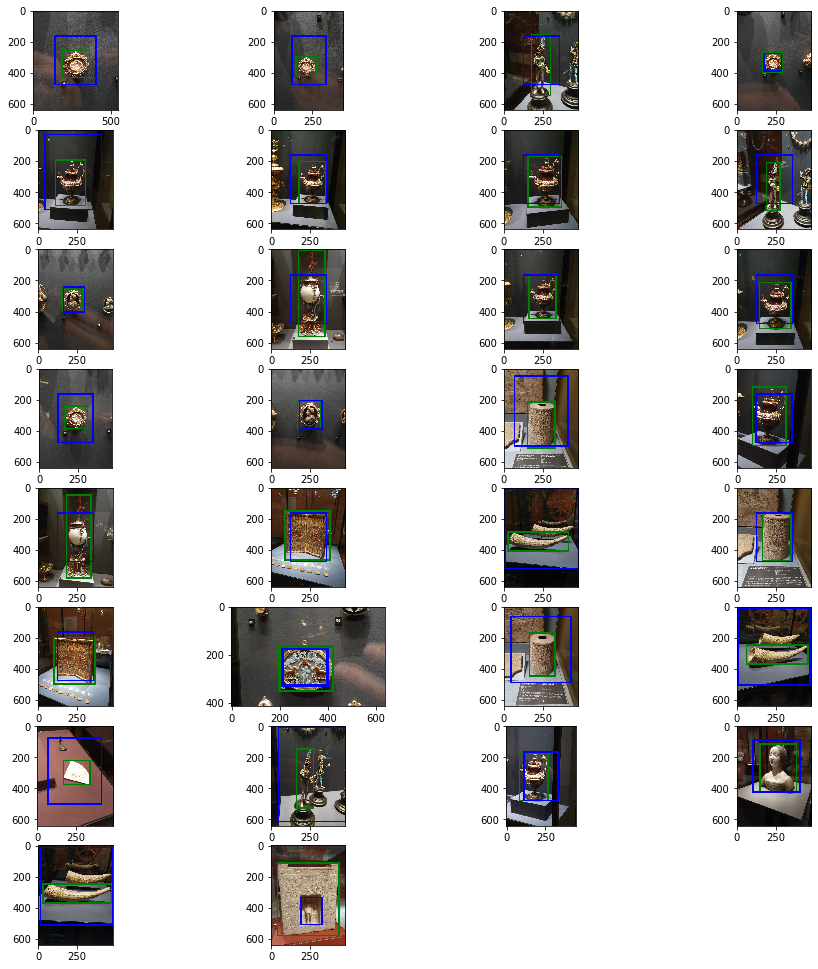

In [25]:
fig = plt.figure(figsize=(16, 140))
columns = 4
rows = 64

for counter, i in enumerate(top_loss_images):
    img = Image.open(i)
    
    img_true = ImageDraw.Draw(img)
    img_true.rectangle(top_loss_boxes_true[counter].tolist(), outline='green', width=10)
    
    img_pred = ImageDraw.Draw(img)
    img_pred.rectangle(top_loss_boxes_pred[counter].tolist(), outline='blue', width=10)
    
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img, aspect='equal')
plt.show()

In [27]:
top_loss_boxes_pred

array([[136.        , 160.        , 408.        , 480.        ],
       [111.5       , 160.        , 334.5       , 480.        ],
       [120.        , 160.        , 360.        , 480.        ],
       [167.42976379, 274.14205933, 289.45275879, 394.18099976],
       [ 41.32149124,  29.6470623 , 411.59490967, 519.03009033],
       [120.        , 160.        , 360.        , 480.        ],
       [120.        , 160.        , 360.        , 480.        ],
       [120.        , 160.        , 360.        , 480.        ],
       [158.75033569, 237.25701904, 301.40136719, 409.10656738],
       [120.        , 160.        , 360.        , 480.        ],
       [120.        , 160.        , 360.        , 480.        ],
       [120.        , 160.        , 360.        , 480.        ],
       [117.        , 160.        , 351.        , 480.        ],
       [177.40470886, 203.50027466, 330.46038818, 394.18276978],
       [ 63.10949707,  47.55976486, 415.02624512, 504.04095459],
       [118.        , 160